In [18]:
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
from astropy.io import fits
from regions import PixCoord, CirclePixelRegion, RectanglePixelRegion
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 16})

In [24]:
os.chdir("/Users/a16472/Desktop/dcf_python/testing/")

def calc_rel_angle_crossn(angle1, angle2, no_rescale=False):

    angle1 = np.array(angle1)
    angle2 = np.array(angle2)

    n = len(angle1)

    if n == 1:
        
        x1 = (-1.0) * np.sin(angle1[0])
        y1 = np.cos(angle1[0])
        x2 = (-1.0) * np.sin(angle2[0])
        y2 = np.cos(angle2[0])
        v1 = np.array([x1, y1, 0])
        v2 = np.array([x2, y2, 0])
        C = np.cross(v1, v2)

        CdC = np.dot(C, C)
        vdgr = np.dot(v1, v2)
        d_ang0 = np.arctan2(np.sqrt(CdC), vdgr)
        
        return np.array([d_ang0])
    
    elif n > 1:
        
        x1 = (-1.0) * np.sin(angle1.reshape(1, n))
        y1 = np.cos(angle1.reshape(1, n))
        x2 = (-1.0) * np.sin(angle2.reshape(1, n))
        y2 = np.cos(angle2.reshape(1, n))
        v1 = np.array([x1, y1, np.zeros((1, n))])
        v2 = np.array([x2, y2, np.zeros((1, n))])
        vi = np.asmatrix(v1).T
        vf = np.asmatrix(v2).T
        
        try:
            C = np.cross(vi, vf)
        except:
            print("crossing error!")

        CdC = np.sum(C * C, 1)

        vdgr = []
        for i in range(len(vi)):
            vector = v1[0][0][i] * v2[0][0][i] + \
                        v1[1][0][i] * v2[1][0][i] + \
                        v1[2][0][i] * v2[2][0][i]
            vdgr.append(vector)

        vdgr = np.array(vdgr)
        d_ang0 = np.arctan2(np.sqrt(CdC), np.abs(vdgr)) #taking the abs here.
        return d_ang0


def Imshow(image, **kwargs):
    """
    Simple function to an image.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image, origin='lower')
    plt.colorbar()
    plt.show()


def pltshow(x, y):
    """
    Show relation between x and y.
    """
    plt.figure(figsize = (10, 10))
    plt.plot(x, y)
    plt.show()

    
def gauss_function(x, a, sigma):
    """
    Gaussian fit function.
    """
    return a * np.exp(-(x)**2 / (2 * sigma**2))


def linear_fit(x, m, b):
    """
    Linear Fit Function.
    """
    return m*x + b

In [78]:
def cos_disp_calculations(data, data_var, ttl='', edge_length):
    """
    """
    x, y, pix_ang, dphi = [], [], [], []

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.isnan(data[i][j]):
                x.append(i)
                y.append(j)
                pix_ang.append(data[i][j])
                dphi.append(data_var[i][j])
                
    x = np.array(x)
    y = np.array(y)
    ang = np.array(pix_ang)
    dphi = np.sqrt(np.array(dphi))

    W = 2.5 / 2.35 # 0.65 pc or 2.5 '' for BlastTNG
    nump = len(ang) 
    delta_r = []
    delta_phi = []
    phi = ang

    for i in range(nump):
        delta_x_arr = x[i] - x[(i+1):(nump)]
        delta_y_arr = y[i] - y[(i+1):(nump)]
        delta_r_arr = np.sqrt(delta_x_arr**2 + delta_y_arr**2)
        sz_phi = len(delta_x_arr)
        phi_ref = np.repeat(phi[i], sz_phi)

        if len(phi_ref) > 0:
            delta_phi_arr = calc_rel_angle_crossn(phi_ref, phi[(i+1):(nump)])
        err_dphi_arr = np.sqrt(dphi[i]**2 + dphi[(i+1):(nump)]**2 - 2.0*dphi[i]*dphi[(i+1):(nump)] * np.exp((-0.25*delta_r_arr**2)/W**2))
        delta_r.append(delta_r_arr)
        delta_phi.append(delta_phi_arr)
        err_dphi.append(err_dphi_arr)

    delta_r = np.array(delta_r)
    delta_phi = np.array(delta_phi[:-1]) # Last value is added twice for some reason.
    err_dphi = np.array(err_dphi)

    delta_r = np.concatenate(delta_r).ravel() * 30 / 60 * ds_scale 
    delta_phi = np.concatenate(delta_phi).ravel()
    err_dphi = np.concatenate(err_dphi).ravel()
    
    pixel_scale = 30 / 60 
    bin_edge = edge_length / pixel_scale
    nbins = round(edge_length / beam_res * 5) # Always want 5 samples / beam.
    bin_edges = (np.linspace(0, bin_edge, nbins)) * pixel_scale 

    cos_disp, bin_edges_norm, bin_number_cos = stats.binned_statistic(delta_r, np.cos(delta_phi), 'mean', bins=bin_edges)
    cos_disp_sq, bin_edges_sq, bin_number_sq = stats.binned_statistic((delta_r)**2, np.cos(delta_phi), 'mean', bins=bin_edges**2)
    err_binned, bin_edges_err, bin_number_err = stats.binned_statistic(delta_r, err_dphi**2, 'mean', bins=bin_edges, range = (0, 1770))
    error_brs = np.sqrt(np.sin(err_binned)**2 * err_binned**2 + (3/4) * np.cos(err_binned)**2 * err_binned**4)

    cos_disp = np.insert(cos_disp, 0, 1)
    cos_disp_sq = np.insert(cos_disp_sq, 0, 1)
    err_binned = np.insert(err_binned, 0, 0)
    
    return [cos_disp, cos_disp_sq, bin_edges_norm, bin_edges_sq, error_brs, err_binned]


def single_fit(lst_cos_disp, fit0, fitf, beam=False, show=True):
    """
    """
    cos_disp = lst_cos_disp[0]
    cos_disp_sq = lst_cos_disp[1]
    bin_edges_norm = lst_cos_disp[2]
    bin_edges_sq = lst_cos_disp[3]
    error_brs = lst_cos_disp[4]
    err_binned = lst_cos_disp[5]
    
    cos_disp_sq = 1-(cos_disp_sq/(1-0.5*err_binned))
    cos_disp = 1-cos_disp/(1-0.5*err_binned)
    
    popt_linear, _ = curve_fit(linear_fit,  bin_edges_sq[fit0:fitf], 1-cos_disp_sq[fit0:fitf]) # Linear Fit
    b2_l = linear_fit(bin_edges_norm**2, *popt_linear) - (1 - cos_disp) # Linear Fit Squared
    popt_gauss, __ = curve_fit(gauss_function, bin_edges_norm, b2_l) # Gaussian Fit
    
    print("Y-intercept (Uncorrected Turbulent-Ordered Ratio): ", popt_linear[-1])
    print('[ Amplitude  Sigma ]')
    print("Gaussian parameters are: ", popt_gauss)
    print("FWHM: ", popt_gauss[1] * 2.35)
    print("Number of Bins: ", nbins)
    
    analytic_turb_cof = np.sqrt(popt_gauss[1]**2 - 2*(W)**2)
    print("Analytic Turbulent Corrleation Length: ", analytic_turb_cof)
    
    fig = plt.figure(num=1, figsize =(12, 12))
    plt.subplot(3, 1, 1)
    plt.title("Dispersion Analysis")
    plt.plot(bin_edges_sq[fit0:fitf],  (1-cos_disp_sq)[fit0:fitf], marker='X', label='Fitting Range', color='r')
    plt.plot(bin_edges_sq, 1-cos_disp_sq, linestyle ="none", marker=".", label=ttl + " Dispersion")
    plt.plot(bin_edges_sq, linear_fit(bin_edges_sq, *popt_linear), linestyle="--")
    plt.ylabel(r'$<1 - COS\phi>$')
    plt.xlabel("L $^2$ ('')", fontsize=11.5)
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(bin_edges_norm[fit0:fitf],  (1-cos_disp)[fit0:fitf], marker='X', label='Fitting Range', linestyle='--', color='r')
    plt.plot(bin_edges_norm, 1-cos_disp, linestyle ="none", marker=".", label = ttl + " Dispersion")
    plt.plot(bin_edges_norm, linear_fit(bin_edges_norm**2, *popt_linear), linestyle="--")
    plt.ylabel(r'$<1 - COS\phi>$')
    plt.xlabel("L ('')", fontsize=11.5)
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(bin_edges_norm, gauss_function(bin_edges_norm, *popt_gauss), linestyle="--", label='Gaussian Fit')
    plt.plot(bin_edges_norm, b2_l, linestyle ="none", marker=".", label=ttl + r' b$^2$(l)')
    if beam:
        beam_gauss = lambda x : popt_gauss[0] * np.exp(-(x)**2 / (2*(2 * W**2)))
        plt.plot(bin_edges_norm, beam_gauss(bin_edges_norm), label='Gaussian Beam Contribution', color='r', linestyle='--')
        plt.plot(bin_edges_norm, total_gauss_function(bin_edges_norm, popt_gauss[0], W, analytic_turb_cof), linestyle ="--", marker=".", label='Analytic Turbulent + Beam', color='g')
    plt.ylabel("b$^2$(l)")
    plt.xlabel("L ('')", fontsize=11.5)
    plt.legend(loc=1)
    if show:
        plt.show()
    return popt_linear[-1], analytic_turb_cof
        
    
def data_cut(x_cen, y_cen, rad, image, show=False):
    if show:
        fig, ax = plt.subplots(figsize=(12, 6))
        region = RectanglePixelRegion(center=PixCoord(x=x_cen, y=y_cen), width=rad, height=rad)
        plt.imshow(image, origin='lower', vmin=0, vmax=np.pi, cmap='hsv')
        plt.colorbar()
        region.plot(ax=ax, color='white')
        plt.show()
    reg = RectanglePixelRegion(center=PixCoord(x=x_cen, y=y_cen), width=rad, height=rad)
    mask = reg.to_mask() 
    mask = reg.to_mask(mode='center')
    dt = mask.cutout(image)
    return dt

SyntaxError: non-default argument follows default argument (<ipython-input-78-5b85d369835a>, line 1)

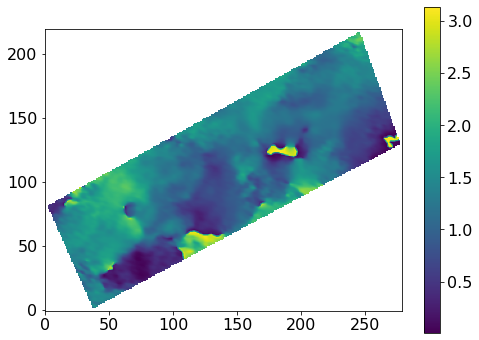

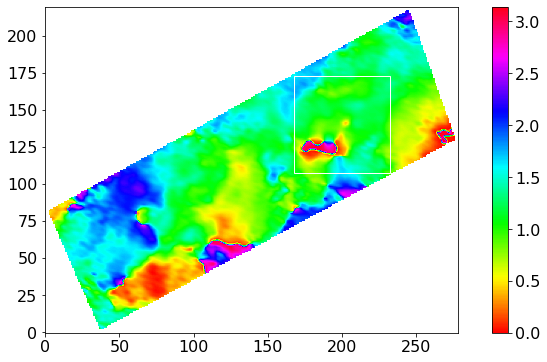

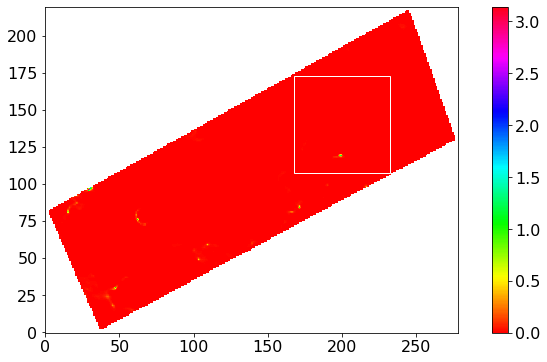

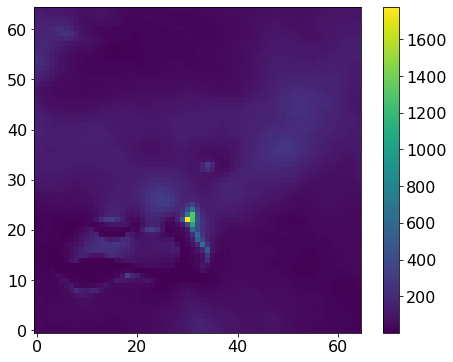

In [59]:
data = fits.open("VelaC_500_intermediate_regrid_30as_pix_ang.fits")[0].data
data_var = fits.open("VelaC_500_intermediate_regrid_30as_pix_var_ang.fits")[0].data
data_mask = np.load("true_masking_velac.npy")
## Selecting Region or regions
y_cen = 140
x_cen = 200
rad = 65

Imshow(data)
dt = data_cut(x_cen, y_cen, rad, data, show=True)
dt_var = data_cut(x_cen, y_cen, rad, data_var*data_mask, show=True)

# print(data.shape)
# masking = np.ones((220, 279))
# locations = np.argwhere(np.isnan(data))
# for coordinate in locations:
#     x = coordinate[0]
#     y = coordinate[1]
#     masking[x][y] = np.nan
# Imshow(masking)
# np.save("true_masking_velac.npy", masking)

snr = dt / np.sqrt(dt_var)
Imshow(snr)

In [79]:
lst_info = cos_disp_calculations()
single_fit(lst_info, 10, 15, beam=False, show=True)

TypeError: cos_disp_calculations() missing 3 required positional arguments: 'data', 'ttl', and 'edge_length'

In [ ]:
# calculate signal to noise.